In [1]:
def setup_environment(isDataExist: bool):
  !pip install kaggle

  from google.colab import drive
  drive.mount('/content/drive')

  import os
  import json
  f = open("/content/drive/MyDrive/kaggle/token/kaggle.json", 'r')
  json_data = json.load(f) 
  os.environ['KAGGLE_USERNAME'] = json_data['username']
  os.environ['KAGGLE_KEY'] = json_data['key']

  if(isDataExist is False):
    !kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -p /content/drive/MyDrive/kaggle/toxic_comment_classification/dataset

    !unzip -o /content/drive/MyDrive/kaggle/toxic_comment_classification/dataset/jigsaw-toxic-comment-classification-challenge.zip -d /content/drive/MyDrive/kaggle/toxic_comment_classification/dataset
    !rm /content/drive/MyDrive/kaggle/toxic_comment_classification/dataset/jigsaw-toxic-comment-classification-challenge.zip
        
    !unzip -o /content/drive/MyDrive/kaggle/toxic_comment_classification/dataset/sample_submission.csv.zip -d /content/drive/MyDrive/kaggle/toxic_comment_classification/dataset
    !unzip -o /content/drive/MyDrive/kaggle/toxic_comment_classification/dataset/test.csv.zip -d /content/drive/MyDrive/kaggle/toxic_comment_classification/dataset   
    !unzip -o /content/drive/MyDrive/kaggle/toxic_comment_classification/dataset/train.csv.zip -d /content/drive/MyDrive/kaggle/toxic_comment_classification/dataset   
    !unzip -o /content/drive/MyDrive/kaggle/toxic_comment_classification/dataset/test_labels.csv.zip -d /content/drive/MyDrive/kaggle/toxic_comment_classification/dataset   
    !rm /content/drive/MyDrive/kaggle/toxic_comment_classification/dataset/*.zip

# setup_environment(isDataExist=False)
setup_environment(isDataExist=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# The following article is referenced in this notebook.
# https://www.kaggle.com/code/sbongo/for-beginners-tackling-toxic-using-keras/notebook

import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [3]:
train = pd.read_csv('/content/drive/MyDrive/kaggle/toxic_comment_classification/dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/kaggle/toxic_comment_classification/dataset/test.csv')

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

In [5]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
list_sentences_train = train["comment_text"] # train text
list_sentences_test = test["comment_text"] # test text
y = train[list_classes].values # scores

display(y)
display(list_sentences_train)

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [9]:
'''
# tokenizer example
sample_tokenizer = Tokenizer(num_words=30) # max number of words to learn
sample_text = ["Hello world, yeah!", "This is an apple, yeah!"]
sample_tokenizer.fit_on_texts(sample_text)

# simple info
print(sample_tokenizer.document_count) 
print(sample_tokenizer.word_counts)
print(sample_tokenizer.word_index)

# vector info
display(sample_tokenizer.texts_to_matrix(sample_text, "binary")) # binary expression based on the word_index
display(sample_tokenizer.texts_to_matrix(sample_text, "count"))  # count expression based on the word_index

# fit
# fit_on_texts produces the one-hot encoding for a text
# https://stackoverflow.com/questions/69026891/what-is-keras-tokenizer-fit-on-texts-doing
sample_tokenizer.fit_on_texts(list(sample_text)) 
sample_tokenizer_list = sample_tokenizer.texts_to_sequences(sample_text) # [[2, 3, 1], [4, 5, 6, 7, 1]]
print(sample_tokenizer_list)
'''

'\n# tokenizer example\nsample_tokenizer = Tokenizer(num_words=30) # max number of words to learn\nsample_text = ["Hello world, yeah!", "This is an apple, yeah!"]\nsample_tokenizer.fit_on_texts(sample_text)\n\n# simple info\nprint(sample_tokenizer.document_count) \nprint(sample_tokenizer.word_counts)\nprint(sample_tokenizer.word_index)\n\n# vector info\ndisplay(sample_tokenizer.texts_to_matrix(sample_text, "binary")) # binary expression based on the word_index\ndisplay(sample_tokenizer.texts_to_matrix(sample_text, "count"))  # count expression based on the word_index\n\n# fit\n# fit_on_texts produces the one-hot encoding for a text\n# https://stackoverflow.com/questions/69026891/what-is-keras-tokenizer-fit-on-texts-doing\nsample_tokenizer.fit_on_texts(list(sample_text)) \nsample_tokenizer_list = sample_tokenizer.texts_to_sequences(sample_text) # [[2, 3, 1], [4, 5, 6, 7, 1]]\nprint(sample_tokenizer_list)\n'

In [6]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features) # max number of words to learn
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [7]:
print(list_tokenized_train[0])
print(list_tokenized_train[1])
print(list_tokenized_train[2])
print(list_tokenized_train[3])

[688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]
[52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182]
[412, 437, 73, 134, 14, 249, 2, 71, 314, 78, 50, 9, 13, 626, 8, 2284, 492, 502, 102, 4, 611, 2, 35, 325, 126, 363, 3, 29, 38, 27, 52, 208, 2, 434, 57, 36, 1, 2394, 93, 1, 737, 468]
[57, 7, 228, 97, 54, 328, 1436, 15, 2133, 7, 6024, 22, 1, 123, 2502, 56, 16, 513, 15, 25, 5, 4236, 3, 1327, 3, 9762, 7, 67, 1, 277, 85, 122, 13503, 37, 9, 51, 19, 42, 10, 1, 1460, 138, 1257, 2153, 426, 1257, 319, 7, 40, 33, 9, 513, 15, 22, 46, 48, 310, 103, 113, 22, 6, 18, 54, 4442, 12, 2394, 275, 15, 277, 25, 105, 2, 33, 11, 206, 45, 267, 35, 69, 41, 542, 2, 16, 5, 5956, 15, 80, 12, 385, 37, 7, 645, 41, 85, 16, 5, 2024, 386, 5, 3057, 3245, 76, 78, 424, 10, 1, 502, 640, 3597, 28, 98, 23, 3542, 4901]

In [8]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # covert to fixed length
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
print(np.shape(list_tokenized_train), np.shape(X_t))
print(np.shape(list_tokenized_train), np.shape(X_te))

(159571,) (159571, 200)
(159571,) (153164, 200)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


[47, 17, 42, 114, 13, 11, 8, 19, 84, 11, 499, 11, 51, 143, 38, 104, 10, 3, 17, 76, 40, 9, 81, 13, 219, 16, 49, 58, 27, 13, 17, 11, 11, 146, 55, 141, 184, 56, 25, 206, 35, 37, 106, 8, 60, 123, 12, 19, 118, 183, 454, 24, 32, 89, 8, 19, 12, 111, 312, 66, 18, 55, 5, 164, 29, 57, 17, 30, 38, 33, 32, 61, 11, 217, 32, 9, 41, 50, 30, 13, 173, 473, 94, 53, 17, 22, 13, 8, 58, 4, 148, 69, 17, 16, 91, 92, 10, 22, 30, 51, 13, 19, 16, 76, 13, 7, 149, 104, 24, 21, 15, 8, 109, 73, 225, 10, 98, 26, 48, 7, 38, 53, 44, 30, 22, 24, 527, 32, 38, 76, 41, 27, 50, 35, 108, 34, 15, 44, 8, 8, 158, 67, 320, 56, 21, 115, 6, 36, 80, 71, 119, 92, 10, 79, 18, 40, 25, 52, 41, 18, 538, 41, 418, 15, 28, 31, 115, 152, 26, 65, 57, 10, 75, 5, 32, 5, 26, 13, 18, 126, 226, 10, 6, 35, 24, 25, 22, 18, 46, 41, 46, 66, 44, 14, 9, 47, 33, 119, 85, 18, 114, 63, 15, 63, 97, 59, 105, 71, 15, 12, 16, 7, 66, 184, 646, 28, 18, 11, 20, 74, 78, 45, 62, 5, 9, 78, 7, 31, 18, 148, 192, 21, 82, 31, 141, 22, 58, 31, 15, 88, 289, 3, 32, 36, 4

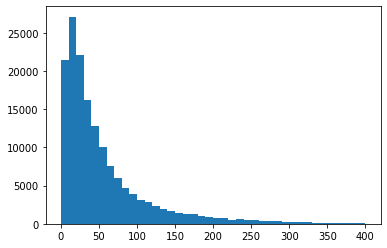

In [9]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
print(totalNumWords)

plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show() # We can see most of the sentence length is < 50

In [10]:
inp = Input(shape=(maxlen, )) 

embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 63s 12ms/step - loss: 0.0688 - accuracy: 0.9600 - val_loss: 0.0492 - val_accuracy: 0.9939
Epoch 2/2
4488/4488 [==============================] - 52s 12ms/step - loss: 0.0448 - accuracy: 0.9919 - val_loss: 0.0474 - val_accuracy: 0.9940


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           45360     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                             

In [12]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_3rd_layer_output([X_t[:1]])[0]
layer_output.shape

(1, 200, 60)

In [13]:
test_label = pd.read_csv('/content/drive/MyDrive/kaggle/toxic_comment_classification/dataset/test_labels.csv')
Y_te = test_label[list_classes].values # scores
display(Y_te)

result = model.evaluate(X_te, Y_te)

array([[-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       ...,
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1]])

4787/4787 [==============================] - 25s 5ms/step - loss: -4.2037 - accuracy: 0.9990


In [14]:
pred = model.predict(X_te)

In [15]:
display(pred.shape)
display(pred)

(153164, 6)

array([[9.9777776e-01, 2.0181832e-01, 9.2693299e-01, 5.4084864e-02,
        9.0168089e-01, 2.4075690e-01],
       [4.0931202e-04, 1.5699297e-07, 1.0423549e-04, 1.5918855e-06,
        6.0282775e-05, 1.1158696e-05],
       [1.3274848e-03, 1.4305898e-06, 4.1515051e-04, 1.1935865e-05,
        2.6183834e-04, 4.9083155e-05],
       ...,
       [2.1603570e-04, 1.6123201e-08, 4.7980458e-05, 1.7156830e-07,
        1.9055196e-05, 2.9425814e-06],
       [2.5479840e-03, 8.7152529e-07, 3.2384900e-04, 1.4605928e-05,
        2.6324810e-04, 1.0575721e-04],
       [9.6880484e-01, 1.0052047e-02, 7.6552010e-01, 1.2208173e-03,
        4.9848807e-01, 9.3627954e-03]], dtype=float32)

In [16]:
submission = pd.DataFrame(pred, columns=[list_classes])
submission.insert(0, 'id', test["id"])

display(submission)
submission.to_csv("/content/drive/MyDrive/kaggle/toxic_comment_classification/dataset/toxic_comment_classification_submission.csv", index=False)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.997778,2.018183e-01,0.926933,5.408486e-02,0.901681,0.240757
1,0000247867823ef7,0.000409,1.569930e-07,0.000104,1.591886e-06,0.000060,0.000011
2,00013b17ad220c46,0.001327,1.430590e-06,0.000415,1.193586e-05,0.000262,0.000049
3,00017563c3f7919a,0.000346,2.659626e-08,0.000074,3.114345e-07,0.000034,0.000004
4,00017695ad8997eb,0.003121,2.938717e-06,0.000639,2.939989e-05,0.000558,0.000124
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.571124,3.763777e-04,0.142697,6.789235e-04,0.096291,0.004605
153160,fffd7a9a6eb32c16,0.005434,3.658608e-06,0.001213,2.962694e-05,0.000782,0.000143
153161,fffda9e8d6fafa9e,0.000216,1.612320e-08,0.000048,1.715683e-07,0.000019,0.000003
153162,fffe8f1340a79fc2,0.002548,8.715253e-07,0.000324,1.460593e-05,0.000263,0.000106


In [17]:
!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f "/content/drive/MyDrive/kaggle/toxic_comment_classification/dataset/toxic_comment_classification_submission.csv" -m "toxic comment classification submission"

100% 13.8M/13.8M [00:07<00:00, 1.90MB/s]
Successfully submitted to Toxic Comment Classification Challenge